This notebook is by Anastasia Ruzmaikina.

Here we analyse a dataset of nearly 5000 movies. The goal is to be able to predict the revenue of the movie given all the information available about the movie. The available data columns are the title, names of actors and actresses, movie genres, vote count, movie budget etc.

Using XGBoost Regression we can predict the revenue of a movie with the R2 score of 0.69, which is the same score we got when we used Linear Regression.

First we download all the Python libraries we need to use.

In [29]:
# Data manipulation
import numpy as np 
import pandas as pd

# Data Visualazation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV 
import xgboost as xgb
# xgboost for performing regression

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import random
import scipy.optimize

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We download the movie data set from Harvard Edx website.

In [2]:
df = pd.read_csv("https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@movie_data.csv", index_col=0)

df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"Action, Crime, Thriller",NaN,9367,"united states–mexico barrier, legs, arms, pape...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,Columbia Pictures,...,2040920,81.0,Español,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,9367,"Carlos Gallardo, Jaime de Hoyos, Peter Marquar..."
4799,9000,"Comedy, Romance",NaN,72766,NaN,en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,NaN,...,0,85.0,NaN,Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,72766,"Edward Burns, Kerry Bishé, Marsha Dietlein, Ca..."
4800,0,"Comedy, Drama, Romance, TV Movie",http://www.hallmarkchannel.com/signedsealeddel...,231617,"date, love at first sight, narration, investig...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"Front Street Pictures, Muse Entertainment Ente...",...,0,120.0,English,Released,NaN,"Signed, Sealed, Delivered",7.0,6,231617,"Eric Mabius, Kristin Booth, Crystal Lowe, Geof..."
4801,0,NaN,http://shanghaicalling.com/,126186,NaN,en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,NaN,...,0,98.0,English,Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7,126186,"Daniel Henney, Eliza Coupe, Bill Paxton, Alan ..."


In [3]:
df.shape

(4803, 22)

We replace infinite values with NaN values in the data frame. NaN values are handled later.

In [6]:
df = df.replace(to_replace = np.inf, value = np.nan)
df = df.replace(to_replace = -np.inf, value = np.nan)

Next we do a one hot encoding of the 'genres' column.

First we identify how many different genres are present in the 'genres' column.

We split the genres into different columns. Each column contains 1's or 0's, one if that particlar genre is present in that row.



In [7]:
genr = []
for i in range(len(df['genres'])):
    temp = df['genres'].iloc[i]
    if not (isinstance(temp, float)):
       temp = temp.split(',')
       genr += temp
       
genre = list(set(genr))
for i in range(len(genre)):
    genre[i] = genre[i].strip()
genre = list(set(genre))
for item in genre:
    df[item] = df['budget']
for item in genre:
    for i in range(len(df['genres'])):
        if not (isinstance(df['genres'].iloc[i], float)):
             if item in df['genres'].iloc[i]:
                   df[item].iloc[i] = 1
             else:
                   df[item].iloc[i] = 0

Before solving the problem, it's very important to have a good understanding of data.

First we get the descriptive statistics of the data 

Then we get the information about missing values in the data



In [9]:
# Info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4391 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4716 non-null   object 
 15  status               

Summary Statistics

In [10]:
# Summary statistic of the data
df.describe()  

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,Horror,Comedy,...,Romance,Drama,Mystery,Crime,Animation,Science Fiction,Action,Adventure,Foreign,Music
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000,4.803000e+03,4.803000e+03,...,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281,7.704601e+02,7.707106e+02,...,7.705382e+02,7.708303e+02,7.704245e+02,7.704970e+02,7.704008e+02,7.704635e+02,7.705923e+02,7.705166e+02,7.703592e+02,7.703906e+02
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033,3.441408e+04,3.441408e+04,...,3.441408e+04,3.441408e+04,3.441409e+04,3.441408e+04,3.441409e+04,3.441408e+04,3.441408e+04,3.441408e+04,3.441409e+04,3.441409e+04
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000,0.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000,2.000000e+06,2.000000e+06,...,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06


Counts of missing values in every column

In [11]:
# Get count of missing values in every column
print(df.isna().sum())

budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies     351
production_countries     174
release_date               1
revenue                    0
runtime                    2
spoken_languages          87
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                      43
Horror                     0
Comedy                     0
Family                     0
Documentary                0
History                    0
Western                    0
Thriller                   0
War                        0
TV Movie                   0
Fantasy                    0
Romance                    0
Drama                      0
Mystery       

Conclusions: 

The data contains some categorical columns, these columns need to be handled before building the model

Some columns have missing values, these need to be handled before building the model

The y variable (revenue) doesn't have any missing values, which is good

In [12]:
# Create list of numeric and categorical columns and check if they have extra spaces in the column names
num_col = df.select_dtypes(include=np.number).columns
print("Numerical columns: \n",num_col)

cat_col = df.select_dtypes(exclude=np.number).columns
print("Categorical columns: \n",cat_col)

Numerical columns: 
 Index(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'movie_id', 'Horror', 'Comedy', 'Family', 'Documentary',
       'History', 'Western', 'Thriller', 'War', 'TV Movie', 'Fantasy',
       'Romance', 'Drama', 'Mystery', 'Crime', 'Animation', 'Science Fiction',
       'Action', 'Adventure', 'Foreign', 'Music'],
      dtype='object')
Categorical columns: 
 Index(['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast'],
      dtype='object')


We already did one hot encoding on the 'genres' column, so we can drop the 'genres' column.

The only categorical column that can influence the 'revenue' column is the 'cast' column. But if we do a one hot encoding, we find that we need a hundred or more columns. Therefore it is impractical to use 'cast' data.

All other categorical columns have very little influence on the revenue from the movie, so we can drop them.

In [13]:
df = df.drop(columns=['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast'])

We are going to drop the columns 'id' and 'movie_id', because they carry no information.

We are going to drop rows with NaN values, because there are only 2 rows with NaN values left.

In [14]:
df = df.drop(columns=['id', 'movie_id'])
df = df.dropna()
print(df.shape)

(4801, 26)


In [15]:
df.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Horror,Comedy,Family,Documentary,...,Romance,Drama,Mystery,Crime,Animation,Science Fiction,Action,Adventure,Foreign,Music
0,237000000,150.437577,2787965087,162.0,7.2,11800,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,300000000,139.082615,961000000,169.0,6.9,4500,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,245000000,107.376788,880674609,148.0,6.3,4466,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
3,250000000,112.312950,1084939099,165.0,7.6,9106,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4,260000000,43.926995,284139100,132.0,6.1,2124,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0


Exploratory data analysis is an approach to analyze or investigate data sets to find out patterns and see if any of the variables can be useful in predicting the y variables. Visual methods are often used to summarise the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.

We are going to:

Create list of columns by data type

Check the distribution of target variable

Check the correlation between different features

Check the relation between different features

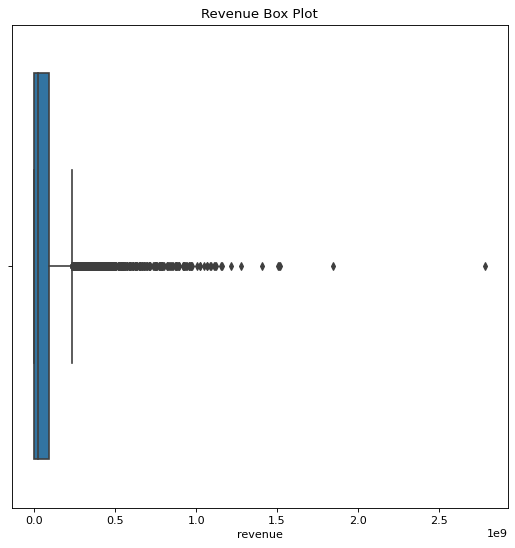

In [16]:
# Check the distribution of y variable (Revenue) using box plot
plt.figure(figsize=(8,8), dpi= 80)
sns.boxplot(df['revenue'])
plt.title('Revenue Box Plot')
plt.show()

<AxesSubplot:title={'center':'Revenue Distribution Plot'}, xlabel='revenue', ylabel='Density'>

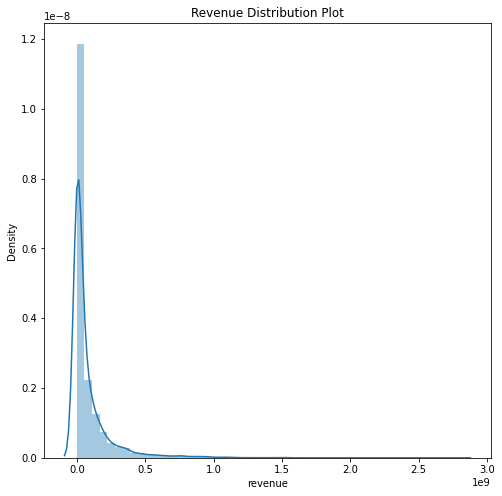

In [17]:
# Check the distribution of y variable (Revenue) using dist plot
plt.figure(figsize=(8,8))
plt.title('Revenue Distribution Plot')
sns.distplot(df['revenue'])

We see that the data set has some very high revenue movies, which contribute to the right skewness of the data. The high kurtosis of the data shows that the data is far from normally distributed.

In [18]:
# Skew and kurt
print("Skewness: %f" % abs(df['revenue']).skew())
print("Kurtosis: %f" % abs(df['revenue']).kurt())

Skewness: 4.443922
Kurtosis: 33.112510


Next we calculate all the correlations between 'revenue' and other columns. We plot the correlations as the heat map.

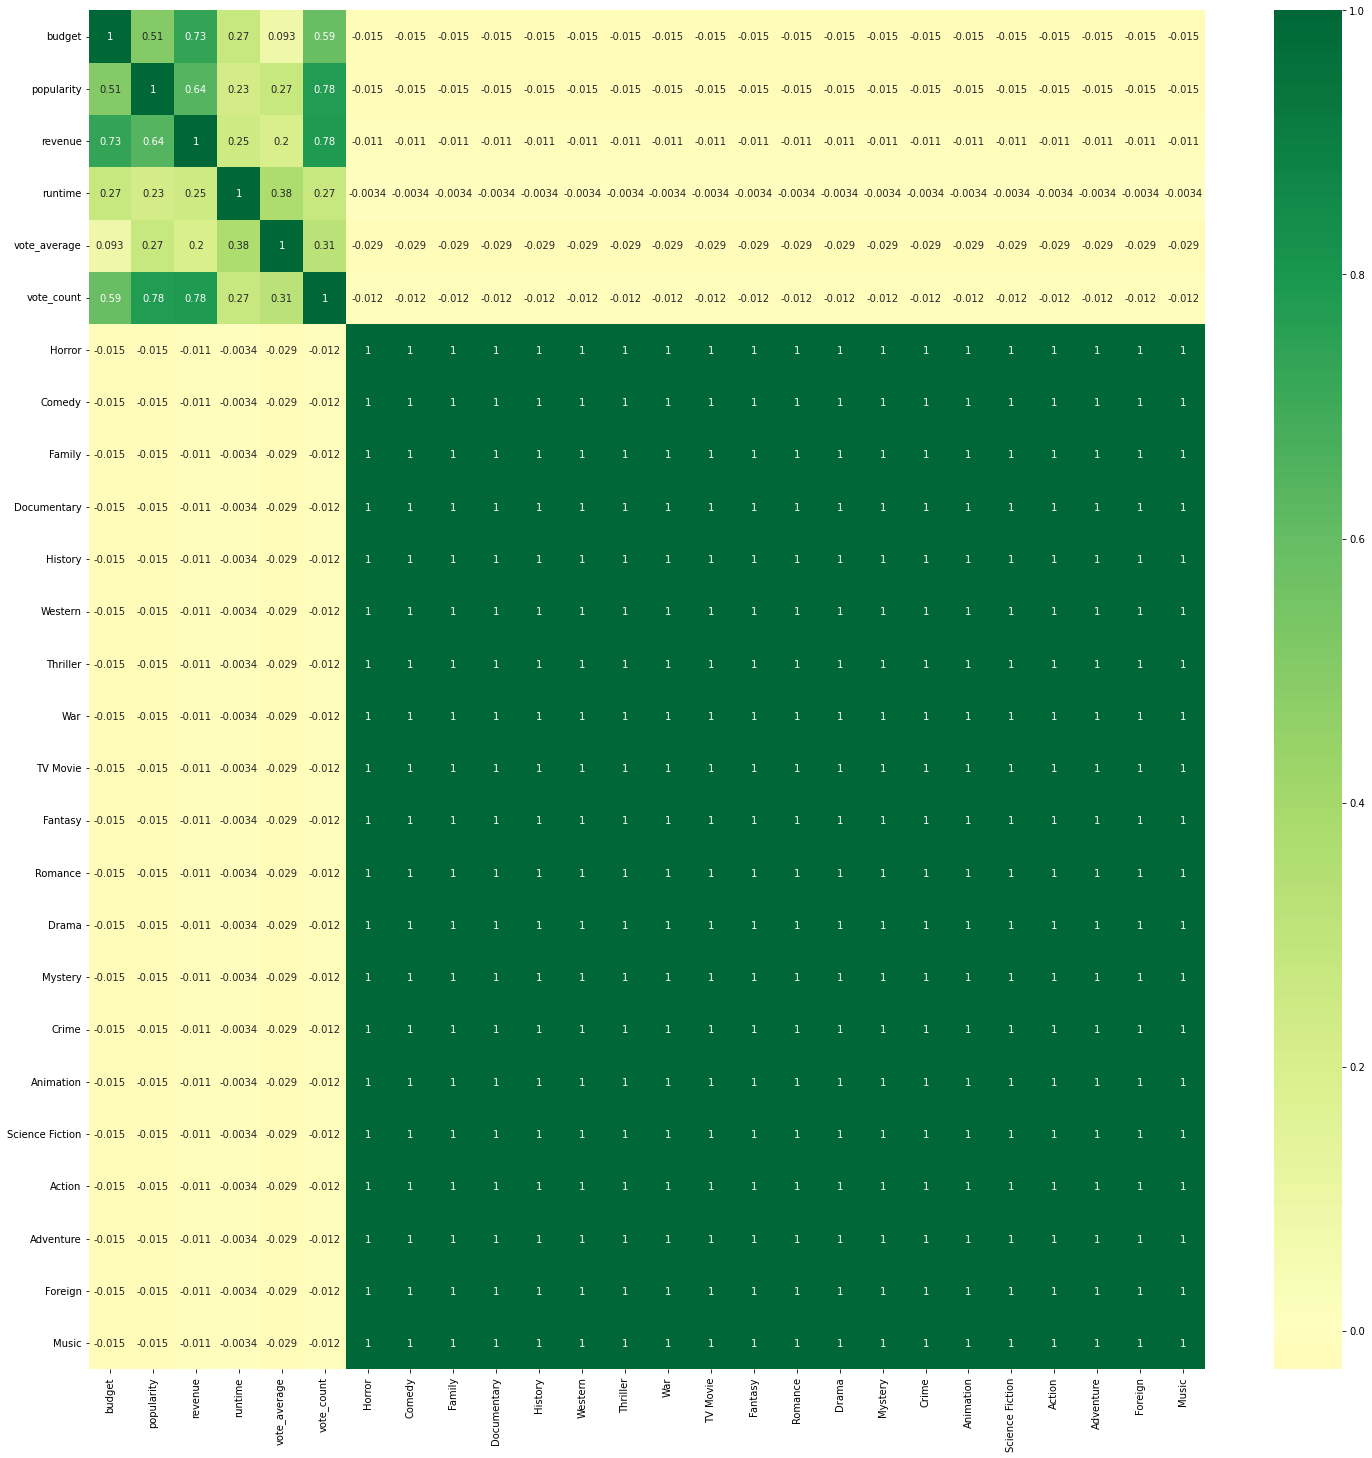

In [19]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0) 

Not all of the features have a significant influence on the 'revenue'.

It is clear that different movie genres have very little influence on the 'revenue'.

Let's look at the correlation matrix of top 7 features, which have the highest correlation with 'revenue'.

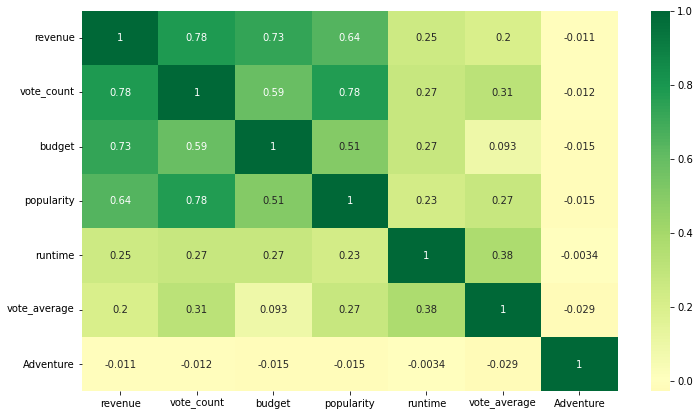

In [20]:
main_columns = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count']
k = 7 #number of variables for heatmap
cols = df.corr().nlargest(k, 'revenue')['revenue'].index
plt.figure(figsize=(12,7))
p = sns.heatmap(df[cols].corr(), annot=True,cmap='RdYlGn',center=0) 

Now we make scatterplots of different covariates vs the 'revenue'.

In [21]:
def scatterplot(x="vote_count", y='revenue'):
    plt.figure(figsize=(10,7))
    plt.scatter(df[x], df[y], )
    plt.title(x + ' vs ' + y)
    plt.show()

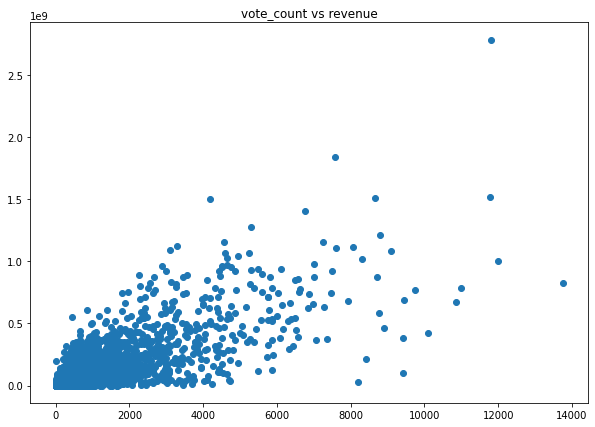

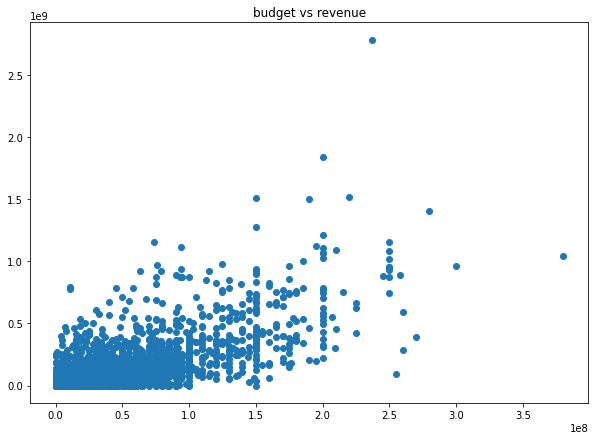

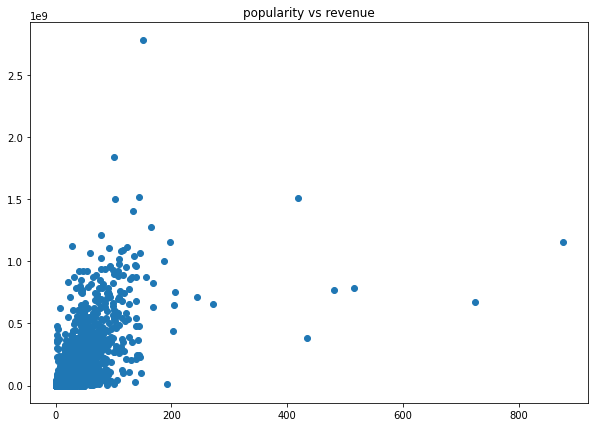

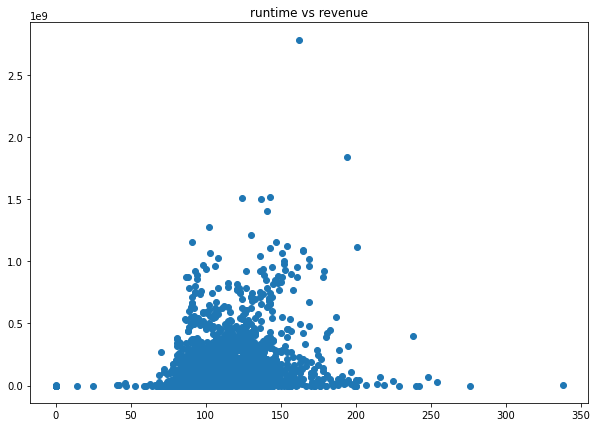

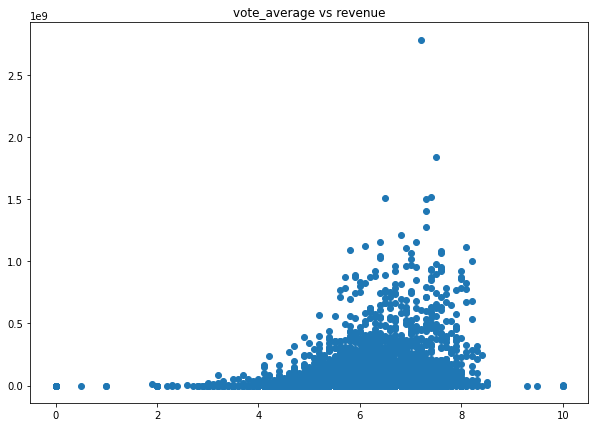

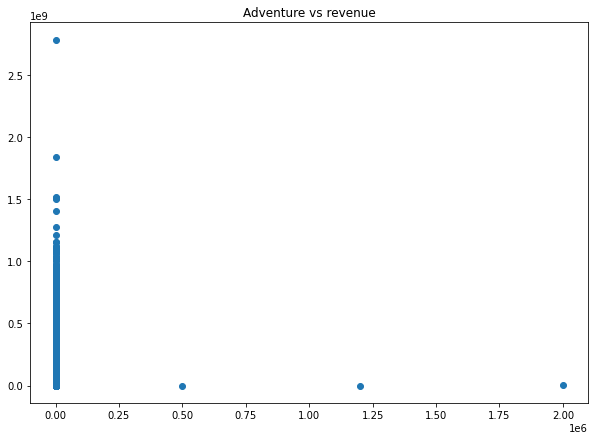

In [22]:
for col in cols[1:]:
    scatterplot(x=col, y='revenue')

We want the highest correlation values between the 'revenue' column and other columns.

In [23]:
# Store 7 highest correlated variables for future reference
corr = df.corr()
print (corr['revenue'].sort_values(ascending=False)[1:7])
highest_correlated_cols = corr['revenue'].sort_values(ascending=False)[1:7].index

vote_count      0.781462
budget          0.730798
popularity      0.644677
runtime         0.251093
vote_average    0.197286
Adventure      -0.011186
Name: revenue, dtype: float64


Model Building

Parameters for Tree Booster (from XGBoost website)

eta [default=0.3, alias: learning_rate] Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. range: [0,1]

gamma [default=0, alias: min_split_loss] Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. range: [0,∞]

max_depth [default=6] Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value. range: [0,∞]

min_child_weight [default=1] Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be. range: [0,∞]

max_delta_step [default=0] Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update. range: [0,∞]

subsample [default=1] Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. range: (0,1]

lambda [default=1, alias: reg_lambda] L2 regularization term on weights. Increasing this value will make model more conservative.

alpha [default=0, alias: reg_alpha] L1 regularization term on weights. Increasing this value will make model more conservative.



Data Preprocessing

We use the standard scaler on the columns to make sure that the columns with the larger values do not influence the target variable more than the columns with the smaller values.

In [61]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
df.iloc[:, 0:6] = StandardScaler().fit_transform(df.iloc[:, 0:6])
data_matrix = df.values

# X: feature matrix (for this analysis, we exclude the 'revenue' variable from the dataset)
X = data_matrix[:, [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]

# y: labels vector
y = data_matrix[:, 2]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

df.head()

X.shape= (4801, 25) y.shape= (4801,)


,budget,popularity,revenue,runtime,vote_average,vote_count,Horror,Comedy,Family,Documentary,...,Romance,Drama,Mystery,Crime,Animation,Science Fiction,Action,Adventure,Foreign,Music
0,5.106231,4.052434,16.612922,2.438088,0.929025,8.998200,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,6.653231,3.695551,5.395284,2.747691,0.677213,3.085524,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,5.302675,2.699047,4.902083,1.818881,0.173591,3.057985,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
3,5.425453,2.854189,6.156275,2.570775,1.264773,6.816180,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4,5.671009,0.704839,1.239331,1.111217,0.005717,1.161069,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0


Train Test Split

In [39]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=100)
#get training and testing data

Model Building

Run XGBoost with the default values of the parameters

In [40]:
xgb_rg = xgb.XGBRegressor()
#initialize the xgb classifier 
xgb_rg.fit(x_train, y_train)

y_pred = xgb_rg.predict(x_test)

Take a look at the predicted values of y

In [41]:
print('Predicted values of y:', y_pred)
print('Actual values of y:', y_test)

Predicted values of y: [ 0.8714143  -0.49448708 -0.4660797  ... -0.4968487   3.417058
  0.19243638]
Actual values of y: [ 0.56259368 -0.50529397 -0.4009133  ... -0.50529397  1.26762949
 -0.20794376]


Take a look at the evaluation metrics

In [42]:
#evaluation metric
print("Test  R2 Score : %.2f"%r2_score(y_test, y_pred))
print("Test  mae Score : %.2f"%mean_absolute_error(y_test, y_pred))
print("Test  mse Score : %.2f"%mean_squared_error(y_test, y_pred))

Test  R2 Score : 0.69
Test  mae Score : 0.27
Test  mse Score : 0.36


The R2 score is 69%, the same as we got when we used Linear Regression.

Try to improve the model

We can increase the maximum depth of the tree

In [43]:
xgb_rg = xgb.XGBRegressor(max_depth = 10)
#initialize the xgb classifier 
xgb_rg.fit(x_train, y_train)

y_pred = xgb_rg.predict(x_test)

Look at the predicted values of y

In [44]:
print('Predicted values of y:', y_pred)
print('Actual values of y:', y_test)

Predicted values of y: [ 0.7829651  -0.51295114 -0.50606215 ... -0.51398605  3.841306
  0.6984657 ]
Actual values of y: [ 0.56259368 -0.50529397 -0.4009133  ... -0.50529397  1.26762949
 -0.20794376]


Look at the evaluation metrics

In [45]:
#evaluation metric
print("Test  R2 Score : %.2f"%r2_score(y_test, y_pred))
print("Test  mae Score : %.2f"%mean_absolute_error(y_test, y_pred))
print("Test  mse Score : %.2f"%mean_squared_error(y_test, y_pred))

Test  R2 Score : 0.69
Test  mae Score : 0.27
Test  mse Score : 0.37


Increasing the maximum tree depth gives no improvement of the R2 score 

Try increasing the number of trees, set the number of trees (n_estimators) to 1000

In [46]:
xgb_rg = xgb.XGBRegressor(max_depth = 10, n_estimators = 1000)
#initialize the xgb classifier 
xgb_rg.fit(x_train, y_train)

y_pred = xgb_rg.predict(x_test)

Look at the predicted values

In [47]:
print('Predicted values of y:', y_pred)
print('Actual values of y:', y_test)

Predicted values of y: [ 0.7841349  -0.5149036  -0.5090043  ... -0.50713927  3.8506002
  0.7292432 ]
Actual values of y: [ 0.56259368 -0.50529397 -0.4009133  ... -0.50529397  1.26762949
 -0.20794376]


Look at the evaluation metrics

In [48]:
#evaluation metric
print("Test  R2 Score : %.2f"%r2_score(y_test, y_pred))
print("Test  mae Score : %.2f"%mean_absolute_error(y_test, y_pred))
print("Test  mse Score : %.2f"%mean_squared_error(y_test, y_pred))

Test  R2 Score : 0.69
Test  mae Score : 0.27
Test  mse Score : 0.37


The R2 score stayed the same

Try to change the learning rate

In [65]:
xgb_rg = xgb.XGBRegressor(max_depth = 10, n_estimators = 1000, learning_rate = 0.1)
#initialize the xgb classifier 
xgb_rg.fit(x_train, y_train)

y_pred = xgb_rg.predict(x_test)

Predicted values of y

In [66]:
print('Predicted values of y:', y_pred)
print('Actual values of y:', y_test)

Predicted values of y: [ 0.7965603  -0.4873584  -0.502733   ... -0.5048233   4.3763895
  0.36799535]
Actual values of y: [ 0.56259368 -0.50529397 -0.4009133  ... -0.50529397  1.26762949
 -0.20794376]


Evaluation metrics

In [67]:
#evaluation metric
print("Test  R2 Score : %.2f"%r2_score(y_test, y_pred))
print("Test  mae Score : %.2f"%mean_absolute_error(y_test, y_pred))
print("Test  mse Score : %.2f"%mean_squared_error(y_test, y_pred))

Test  R2 Score : 0.69
Test  mae Score : 0.27
Test  mse Score : 0.37


Since the R2 score did not change, we should try a Grid Search to see if we can find better values of hyperparameters

In [55]:
from sklearn.model_selection import GridSearchCV
#import grid searchcv for hypeparameter tuning

xgb_clf = xgb.XGBRegressor() #reg:linear for regression task
params = {
        'colsample_bytree':[0.8, 1],
        'n_estimators': [1000, 2000],
        'max_depth': [3, 5],
        'gamma':[0, 0.1, 0.3],
        'reg_alpha':[0.01, 0.85],
        'reg_lambda':[0.45, 1] 
        }
#define params 


grid_search = GridSearchCV(xgb_clf, params, n_jobs=-1, cv = 3, verbose=1)

grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=Non

The best values of the parameters are

In [56]:
#let's see the best parameters as per our grid search
grid_search.best_params_

{'colsample_bytree': 1,
 'gamma': 0.3,
 'max_depth': 3,
 'n_estimators': 1000,
 'reg_alpha': 0.85,
 'reg_lambda': 1}

The Evaluation Metrics for the best parameters are

In [57]:
y_pred = xgb_rg.predict(x_test)

#evaluation metric
print("Test  R2 Score : %.2f"%r2_score(y_test, y_pred))
print("Test  mae Score : %.2f"%mean_absolute_error(y_test, y_pred))
print("Test  mse Score : %.2f"%mean_squared_error(y_test, y_pred))

Test  R2 Score : 0.69
Test  mae Score : 0.27
Test  mse Score : 0.37


We have the same R2 score as before

Try another Grid Search with parameter values closer to the best parameter values found in the previous Grid Search

In [58]:
from sklearn.model_selection import GridSearchCV
#import grid searchcv for hypeparameter tuning

xgb_clf = xgb.XGBRegressor() #reg:linear for regression task
params = {
        'colsample_bytree':[0.95, 1],
        'n_estimators': [50, 500, 1000],
        'max_depth': [2, 3, 4],
        'gamma':[0.3, 0.5],
        'reg_alpha':[0.85, 1],
        'reg_lambda':[0.95, 1] 
        }
#define params 


grid_search = GridSearchCV(xgb_clf, params, n_jobs=-1, cv = 3, verbose=1)

grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=Non

The best values of the parameters are

In [59]:
#let's see the best parameters as per our grid search
grid_search.best_params_

{'colsample_bytree': 1,
 'gamma': 0.5,
 'max_depth': 3,
 'n_estimators': 50,
 'reg_alpha': 0.85,
 'reg_lambda': 0.95}

The Evaluation Metrics for the best values of the parameters are

In [60]:
y_pred = xgb_rg.predict(x_test)

#evaluation metric
print("Test  R2 Score : %.2f"%r2_score(y_test, y_pred))
print("Test  mae Score : %.2f"%mean_absolute_error(y_test, y_pred))
print("Test  mse Score : %.2f"%mean_squared_error(y_test, y_pred))

Test  R2 Score : 0.69
Test  mae Score : 0.27
Test  mse Score : 0.37


Conclusion: XGBoost Regression algorithm gives high R2 scores but it is very difficult to improve on the R2 score corresponding to the default hyperparameter values.